# Measuring Circadian Effect on Team Stats
The circadian rhythm is the body's natural process of regulating sleep. In sports, the effects of traveling across time zones on athletic performance is attributed to the circadian rhythm. The goal of this notebook is to evaluate if there is a significant effect of travel on the Erie Otters performance.

In [1]:
import pandas as pd
import numpy as np
import pprint
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

## Data Wrangling
We need to get stats for individual games of the Erie Otters. Also, the location (home/away) of games needs to be tracked.

In [2]:
# Read in data set
path = 'data/df_all_events.pkl'
df = pd.read_pickle(path)

In [3]:
# convert dataframe to iterable python dict
events = df.to_dict(orient='records')

In [4]:
# count the number of events per game
games = {}
cur_date = ''
# num_home_games = 0
# num_away_games = 0
game_dict = {
    'home' : 0,
    'dump_retained': 0,       # successful dump in attempt
    'dump_lost': 0,           # unsuccessful dump in attempt
    'faceoff_win': 0,         # face off won
    'faceoff_lost': 0,        # face off lost
    'goals': 0,               # goals
    'shots_attempts': 0,      # total shots
    'shots_on_net': 0,        # number of shots on goal
    'shots_missed': 0,        # number of attempted shots that miss net
    'shots_blocked': 0,       # number of attempted shots that are blocked
    'zone_entry_carried': 0,  # puck carried into offensive zone
    'zone_entry_dumped': 0,   # puck dumped into offesnive zone
    'zone_entry_played': 0,   # puck played into offesnive zone via pass
    'penalty_taken': 0,       # number of penalties taken
    'play_indirect': 0,       # successful indirect passes (i.e. pass rimmed of boards)
    'play_direct': 0,         # successful direct passes (i.e. tape to tape pass)
    'inc_play_indirect': 0,   # unsuccessful indirect passes (i.e. pass rimmed of boards)
    'inc_play_direct': 0,     # unsuccessful direct passes (i.e. tape to tape pass)
    
    'shots_on_net_against': 0,
    'play_indirect_against': 0,       # successful indirect passes (i.e. pass rimmed of boards)
    'play_direct_against': 0,         # successful direct passes (i.e. tape to tape pass)
    'inc_play_indirect_against': 0,   # unsuccessful indirect passes (i.e. pass rimmed of boards)
    'inc_play_direct_against': 0,     # unsuccessful direct passes (i.e. tape to tape pass)
    
}

date_change = 0
for e in events:
    if e['game_date'] != cur_date:
        date_change += 1
        cur_date = e['game_date']
        games[cur_date] = game_dict.copy()
        if e['home_team'] == 'Erie Otters':  # figure out if this game is home or away
            games[cur_date]['home'] = 1
#         if e['home_team'] == 'Erie Otters': 
#             print('date changed to ' + cur_date + ' | Home game')
#             num_home_games += 1
#         else: 
#             print('date changed to ' + cur_date + ' |              Away game')
#             num_away_games += 1
        
    # identify negative events...things like shots against, faceoffs lost
    event_name = ''
    if e['team'] != 'Erie Otters':
        if e['event'] == 'Faceoff Win': event_name = 'faceoff_lost'
        elif e['event'] == 'Shot' and e['detail_2'] == 'On Net': event_name = 'shots_on_net_against'
        elif e['event'] == 'Play' and e['detail_1'] == 'Indirect': event_name = 'play_indirect_against'
        elif e['event'] == 'Play' and e['detail_1'] == 'Direct': event_name = 'play_direct_against'
        elif e['event'] == 'Incomplete Play' and e['detail_1'] == 'Indirect': event_name = 'inc_play_indirect_against'
        elif e['event'] == 'Incomplete Play' and e['detail_1'] == 'Direct': event_name = 'inc_play_direct_against'
        if len(event_name) > 0:
            games[cur_date][event_name] += 1
        continue
    
    # we only want to track Erie players
    if e['team'] != 'Erie Otters':
        continue
    
    # identify event that happend
    if e['event'] == 'Dump In/Out' and e['detail_1'] == 'Lost': event_name = 'dump_lost'
    elif e['event'] == 'Dump In/Out' and e['detail_1'] == 'Retained': event_name = 'dump_retained'
    elif e['event'] == 'Faceoff Win': event_name = 'faceoff_win'
    elif e['event'] == 'Goal': event_name = 'goals'   
    elif e['event'] == 'Shot': 
        games[cur_date]['shots_attempts'] += 1
        if e['detail_2'] == 'On Net': event_name = 'shots_on_net'
        elif e['detail_2'] == 'Missed': event_name = 'shots_missed'
        elif e['detail_2'] == 'Blocked': event_name = 'shots_blocked'
    elif e['event'] == 'Zone Entry' and e['detail_1'] == 'Carried': event_name = 'zone_entry_carried'
    elif e['event'] == 'Zone Entry' and e['detail_1'] == 'Dumped': event_name = 'zone_entry_dumped'
    elif e['event'] == 'Zone Entry' and e['detail_1'] == 'Played': event_name = 'zone_entry_played'
    elif e['event'] == 'Penalty Taken': event_name = 'penalty_taken'
    elif e['event'] == 'Play' and e['detail_1'] == 'Indirect': event_name = 'play_indirect'
    elif e['event'] == 'Play' and e['detail_1'] == 'Direct': event_name = 'play_direct'
    elif e['event'] == 'Incomplete Play' and e['detail_1'] == 'Indirect': event_name = 'inc_play_indirect'
    elif e['event'] == 'Incomplete Play' and e['detail_1'] == 'Direct': event_name = 'inc_play_direct'


    # if identified an event we care about, increment that stat
    if len(event_name) > 0:
        games[cur_date][event_name] += 1
        
# print('\ntotal games: ' + str(date_change))
# print('total home games: ' + str(num_home_games))
# print('total away games: ' + str(num_away_games))

# count number of home/away games
count = 0
count_away = 0
for date, value in games.items():
    if value['home'] == 1: count +=1
    else: count_away += 1
print('num home games: ' + str(count))
print('num away games: ' + str(count_away))

num home games: 19
num away games: 21


In [5]:
pprint.pprint(games['2019-09-20'])

{'dump_lost': 25,
 'dump_retained': 8,
 'faceoff_lost': 33,
 'faceoff_win': 26,
 'goals': 5,
 'home': 1,
 'inc_play_direct': 92,
 'inc_play_direct_against': 79,
 'inc_play_indirect': 51,
 'inc_play_indirect_against': 56,
 'penalty_taken': 3,
 'play_direct': 219,
 'play_direct_against': 179,
 'play_indirect': 120,
 'play_indirect_against': 91,
 'shots_attempts': 68,
 'shots_blocked': 16,
 'shots_missed': 19,
 'shots_on_net': 33,
 'shots_on_net_against': 25,
 'zone_entry_carried': 51,
 'zone_entry_dumped': 22,
 'zone_entry_played': 10}


## Data Analysis
Using 2-sample t-tests, check for significant difference in sample means of home vs away stats

In [6]:
df_games = pd.DataFrame.from_dict(games, orient='index')
df_games['play_total'] = df_games['play_direct'] + df_games['play_indirect']
df_games['inc_play_total'] = df_games['inc_play_direct'] + df_games['inc_play_indirect']
df_games['play_attempts'] = df_games['play_total'] + df_games['inc_play_total']

df_games['play_against_total'] = df_games['play_direct_against'] + df_games['play_indirect_against']
df_games['inc_play_against_total'] = df_games['inc_play_direct_against'] + df_games['inc_play_indirect_against']
df_games['play_attempts_against'] = df_games['play_against_total'] + df_games['inc_play_against_total']

df_home = df_games[df_games['home']==1]
df_away = df_games[df_games['home']==0]

In [7]:
df_games.head()

,home,dump_retained,dump_lost,faceoff_win,faceoff_lost,goals,shots_attempts,shots_on_net,shots_missed,shots_blocked,...,play_indirect_against,play_direct_against,inc_play_indirect_against,inc_play_direct_against,play_total,inc_play_total,play_attempts,play_against_total,inc_play_against_total,play_attempts_against
2019-09-20,1,8,25,26,33,5,68,33,19,16,...,91,179,56,79,339,143,482,270,135,405
2019-09-21,0,4,44,32,27,8,67,25,25,17,...,73,168,36,66,362,113,475,241,102,343
2019-09-26,0,5,41,23,30,1,44,18,12,14,...,98,218,34,85,264,145,409,316,119,435
2019-10-04,1,14,62,31,27,2,71,25,32,14,...,70,257,35,84,316,86,402,327,119,446
2019-10-11,1,14,56,39,25,1,87,37,34,16,...,75,175,35,75,340,116,456,250,110,360


##### T-Tests
Compute 2-sample t-tests for all tracked metrics for home vs away games

In [8]:
tmp = df_games.columns.values.tolist()
sig_results = []
t_results = []
for c in tmp:
    print('2-sample t-test for the total number of ' + c + ' for home and away games')
    t_result = ttest_ind(df_home[c], df_away[c], equal_var=False)
    print(t_result)
    if t_result.pvalue < 0.05:
        print('    SIGNIFICANT')
        sig_results.append(c)
        t_results.append(t_result)
    print()
    
print('Metrics that significantly differ for home and away games')
pprint.pprint(sig_results)

2-sample t-test for the total number of home for home and away games
Ttest_indResult(statistic=inf, pvalue=0.0)
    SIGNIFICANT

2-sample t-test for the total number of dump_retained for home and away games
Ttest_indResult(statistic=0.6829069153235562, pvalue=0.499349841953708)

2-sample t-test for the total number of dump_lost for home and away games
Ttest_indResult(statistic=-0.5122268329257181, pvalue=0.6116860812777889)

2-sample t-test for the total number of faceoff_win for home and away games
Ttest_indResult(statistic=2.0581894826208815, pvalue=0.04726973408074997)
    SIGNIFICANT

2-sample t-test for the total number of faceoff_lost for home and away games
Ttest_indResult(statistic=-2.068958465796127, pvalue=0.04577071341613561)
    SIGNIFICANT

2-sample t-test for the total number of goals for home and away games
Ttest_indResult(statistic=-0.7904158033168959, pvalue=0.4344380005671131)

2-sample t-test for the total number of shots_attempts for home and away games
Ttest_indRes

In [9]:
# eliminte indicator variable for home games...this is not a quantitative variable we need to test for significance
sig_results = sig_results[1:]
t_results = t_results[1:]

### Data Visualization
##### Box Plots
For each metric that we found a significant difference in the means of home and away games, print a boxplot using matplotlib

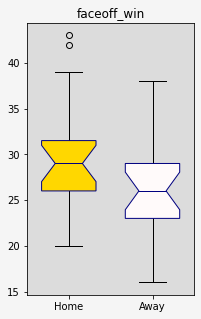

Ttest_indResult(statistic=2.0581894826208815, pvalue=0.04726973408074997)


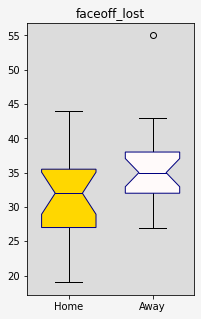

Ttest_indResult(statistic=-2.068958465796127, pvalue=0.04577071341613561)


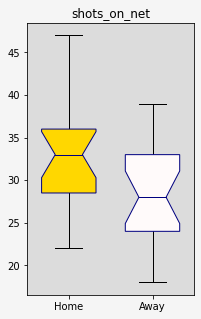

Ttest_indResult(statistic=2.1183561631041536, pvalue=0.04106054220306165)


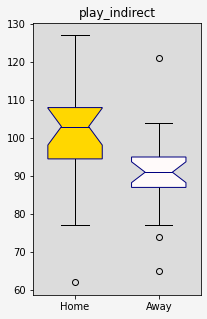

Ttest_indResult(statistic=2.234614183038927, pvalue=0.03251445256796609)


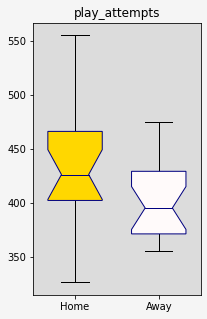

Ttest_indResult(statistic=2.318215106589002, pvalue=0.02727461529386423)


In [10]:
count = 0
for c in sig_results:
    fig = plt.figure(figsize=(3,5))
    fig.patch.set_facecolor('whitesmoke')
    fig.add_subplot(111).patch.set_facecolor('gainsboro')
    data = [df_home[c], df_away[c]]
    ax = plt.boxplot(data, 
                        widths=0.65, 
                        notch=True,
                        boxprops=dict(color='navy'),
                        medianprops=dict(color='navy'),
                        patch_artist=True
                    )
    colors = ['gold', 'snow']
    for patch, color in zip(ax['boxes'], colors):
        patch.set_facecolor(color)
    plt.title(c)
    plt.xticks([1,2], ['Home', 'Away'])
    plt.show()
    fig.savefig(str('output/' + c + '_team'), dpi=fig.dpi)
    print(t_results[count])
    count += 1

In [11]:
print('Home game means for significant metrics:')
print(df_home[['faceoff_win', 'shots_on_net', 'play_indirect', 'play_attempts']].mean())
print()
print('Away game means for significant metrics:')
print(df_away[['faceoff_win', 'shots_on_net', 'play_indirect', 'play_attempts']].mean())

Home game means for significant metrics:
faceoff_win       29.578947
shots_on_net      32.315789
play_indirect    100.210526
play_attempts    435.000000
dtype: float64

Away game means for significant metrics:
faceoff_win       25.761905
shots_on_net      28.238095
play_indirect     90.190476
play_attempts    401.095238
dtype: float64


In [12]:
df_home_means = df_home[['faceoff_win', 'shots_on_net', 'play_indirect', 'play_attempts']].mean()
df_away_means = df_away[['faceoff_win', 'shots_on_net', 'play_indirect', 'play_attempts']].mean()
print('Difference in sample means (home - away)')
print(df_home_means - df_away_means)

Difference in sample means (home - away)
faceoff_win       3.817043
shots_on_net      4.077694
play_indirect    10.020050
play_attempts    33.904762
dtype: float64
